# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

### The Game of Ur problem

In the Royal Game of Ur, players advance tokens along a track with 14 spaces.  To determine how many spaces to advance, a player rolls 4 dice with 4 sides.  Two corners on each die are marked; the other two are not.  The total number of marked corners -- which is 0, 1, 2, 3, or 4 -- is the number of spaces to advance.

For example, if the total on your first roll is 2, you could advance a token to space 2.  If you roll a 3 on the next roll, you could advance the same token to space 5.

Suppose you have a token on space 13.  How many rolls did it take to get there?

Hint: you might want to start by computing the distribution of k given n, where k is the number of the space and n is the number of rolls.

Then think about the prior distribution of n.

Here's a Pmf that represents one of the 4-sided dice.

In [2]:
die = Pmf([0, 1])

Pmf({0: 0.5, 1: 0.5})

And here's the outcome of a single roll.

In [3]:
roll = sum([die]*4)

Pmf({0: 0.0625, 1: 0.25, 2: 0.375, 3: 0.25, 4: 0.0625})

I'll start with a simulation, which helps in two ways: it makes modeling assumptions explicit and it provides an estimate of the answer.

The following function simulates playing the game over and over; after every roll, it yields the number of rolls and the total so far.  When it gets past the 14th space, it starts over.

In [4]:
def roll_until(iters):
    """Generates observations of the game.
    
    iters: number of observations
    
    yields: number of rolls, total
    """
    for i in range(iters):
        total = 0
        for n in range(1, 1000):
            total += roll.Random()
            if total > 14:
                break
            yield(n, total)

Run the simulation many times and, every time the token is observed on space 13, record the number of rolls it took to get there.

In [5]:
pmf_sim = Pmf()
for n, k in roll_until(1000000):
    if k == 13:
        pmf_sim[n] += 1

Here's the distribution of the number of rolls:

In [6]:
pmf_sim.Normalize()

500957

In [7]:
pmf_sim.Print()

4 0.016975508876011312
5 0.14688885473204286
6 0.2973069544891078
7 0.280463193447741
8 0.16114756356333976
9 0.06730517788951945
10 0.022137628578899983
11 0.006052415676395379
12 0.0013933331603311263
13 0.00028146128310413865
14 3.99235862559062e-05
15 5.988537938385929e-06
16 1.9961793127953097e-06


Now let's see if we can compute the likeihood function, which is the probability of being on space 13 after a hypothetical `n` rolls.

`pmf_n` is the distribution of spaces after `n` rolls.

`pmf_13` is the probability of being on space 13 after `n` rolls.

In [8]:
pmf_13 = Pmf()
for n in range(4, 15):
    pmf_n = sum([roll]*n)
    pmf_13[n] = pmf_n[13]
    
pmf_13.Print()
pmf_13.Total()

4 0.008544921875
5 0.0739288330078125
6 0.14878177642822266
7 0.13948291540145874
8 0.08087921887636185
9 0.033626414369791746
10 0.010944152454612777
11 0.002951056014353526
12 0.0006854188303009323
13 0.00014100133496341982
14 2.6227807875534026e-05


0.4999919364007537

The total probability of the data is very close to 1/2, but it's not obvious (to me) why.

Nevertheless, `pmf_13` is the probability of the data for each hypothetical values of `n`, so it is the likelihood function.

Now we need to think about a prior distribution on the number of rolls.  This is not easy to reason about, so let's start by assuming that it is uniform, and see where that gets us.

If the prior is uniform, the posterior equals the likelihood function, normalized.

In [9]:
posterior = pmf_13.Copy()
posterior.Normalize()
posterior.Print()

4 0.017090119365747274
5 0.1478600505840099
6 0.2975683518003199
7 0.2789703298127999
8 0.16176104650522904
9 0.0672539133567936
10 0.021888657911956433
11 0.005902207214774348
12 0.0013708597687294604
13 0.00028200721791321923
14 5.245646172683854e-05


That sure looks similar to what we got by simulation.  Let's compare them.

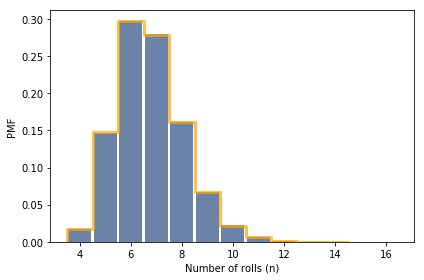

In [10]:
thinkplot.Hist(pmf_sim)
thinkplot.Pmf(posterior, color='orange')
thinkplot.decorate(xlabel='Number of rolls (n)',
                   ylabel='PMF')

Since the posterior distribution based on a uniform prior matches the simulation, it seems like the uniform prior must be correct.  But it is not obvious (to me) why.